In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random

In [2]:
accounts = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
accounts.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90


In [3]:
consumer = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')
consumer = consumer[consumer["DQ_TARGET"].notna()]
consumer.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0


In [4]:
# proportion of delinquent consumers

consumer["DQ_TARGET"].value_counts()

DQ_TARGET
0.0    10994
1.0     1006
Name: count, dtype: int64

In [5]:
categories = pd.read_csv('../../data/q2-ucsd-cat-map.csv')
categories.head()

,category_id,category
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS


In [6]:
transactions = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')
transactions.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16


In [7]:
total_trans = transactions.groupby("prism_consumer_id")[["amount"]].sum()
total_trans

,amount
prism_consumer_id,
0,29295.23
1,48002.17
10,42343.16
100,74979.45
1000,156268.06
...,...
9995,33973.23
9996,2390.92
9997,33909.03


In [8]:
total_acc = accounts.groupby("prism_consumer_id")[["balance"]].sum()
total_acc

,balance
prism_consumer_id,
0,320.37
1,3302.42
10,824.24
100,2655.47
1000,95.25
...,...
9995,0.00
9996,252.67
9997,611.28


In [9]:
spend_balance = total_trans.merge(total_acc, how="inner", on="prism_consumer_id")
spend_balance["spending_balance_ratio"] = spend_balance["amount"] / (spend_balance["balance"] + 1)
spend_balance_dq = spend_balance.merge(consumer, how="inner", on="prism_consumer_id")
spend_balance_dq.head()

,prism_consumer_id,amount,balance,spending_balance_ratio,evaluation_date,credit_score,DQ_TARGET
0,0,29295.23,320.37,91.157326,2021-09-01,726.0,0.0
1,1,48002.17,3302.42,14.531053,2021-07-01,626.0,0.0
2,10,42343.16,824.24,51.310116,2022-02-01,654.0,0.0
3,100,74979.45,2655.47,28.225220,2021-12-01,750.0,0.0
4,1000,156268.06,95.25,1623.564260,2021-03-01,756.0,0.0


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import warnings


def run_classification(
    feature_column, target_column, dataset, test_size=0.2, random_state=42
):
    """
    Run Logistic Regression and Random Forest Classification on a dataset.

    Parameters:
        feature_column (list): List of columns that can be used as features.
        target_column (str): The name of the target column.
        dataset (pd.DataFrame): The dataset containing the features and target.
        test_size (float): Proportion of the dataset to include in the test split (default 0.3).
        random_state (int): Random seed for reproducibility (default 42).

    Returns:
        None: Prints the classification reports for both models.
    """
    warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)

    # Drop NaN values and shuffle the dataset
    dataset = dataset.dropna()

    # Define features and target
    X = dataset[feature_column]
    y = dataset[target_column]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # balance the dataset
    resampler = SMOTETomek(random_state=random_state)
    X_train, y_train = resampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Logistic Regression
    log_model = LogisticRegression(class_weight="balanced", max_iter = 200)
    log_model.fit(X_train, y_train)
    log_y_pred = log_model.predict(X_test)
    log_y_proba = log_model.predict_proba(X_test)[:, 1]
    print(f"Logistic Regression for {feature_column}")
    print(classification_report(y_test, log_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, log_y_proba):.3f}")

    # Random Forest Classification
    rfc_model = RandomForestClassifier(random_state=random_state)
    rfc_model.fit(X_train, y_train)
    rfc_y_pred = rfc_model.predict(X_test)
    rfc_y_proba = rfc_model.predict_proba(X_test)[:, 1]
    print(f"\nRandom Forest Classification for {feature_column}")
    print(classification_report(y_test, rfc_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, rfc_y_proba):.3f}")

    # Light GBM
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    lgb_y_pred = lgb_model.predict(X_test)
    lgb_y_proba = lgb_model.predict_proba(X_test)[:, 1]
    print(f"\nLGB Model Classification for {feature_column}")
    print(classification_report(y_test, lgb_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, lgb_y_proba):.3f}")


    # Balanced Random Forest
    brf_model = BalancedRandomForestClassifier(random_state=random_state)
    brf_model.fit(X_train, y_train)
    brf_y_pred = brf_model.predict(X_test)
    brf_y_proba = brf_model.predict_proba(X_test)[:, 1]
    print(f"\nBalanced Random Forest Classification for {feature_column}")
    print(classification_report(y_test, brf_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, brf_y_proba):.3f}")

In [11]:
run_classification(["spending_balance_ratio"], "DQ_TARGET", spend_balance_dq)

Logistic Regression for ['spending_balance_ratio']
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      1855
         1.0       0.21      0.16      0.19       170

    accuracy                           0.88      2025
   macro avg       0.57      0.55      0.56      2025
weighted avg       0.87      0.88      0.87      2025

ROC-AUC Score: 0.646

Random Forest Classification for ['spending_balance_ratio']
              precision    recall  f1-score   support

         0.0       0.93      0.68      0.79      1855
         1.0       0.11      0.43      0.18       170

    accuracy                           0.66      2025
   macro avg       0.52      0.56      0.48      2025
weighted avg       0.86      0.66      0.74      2025

ROC-AUC Score: 0.587
[LightGBM] [Info] Number of positive: 5697, number of negative: 5697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_

In [12]:
cons_acc = consumer.merge(accounts, how="inner", on="prism_consumer_id")
cons_acc

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance
0,0,2021-09-01,726.0,0.0,862,SAVINGS,2021-08-31,25.70
1,0,2021-09-01,726.0,0.0,863,CHECKING,2021-08-31,294.67
2,1,2021-07-01,626.0,0.0,7754,SAVINGS,2021-06-30,3211.18
3,1,2021-07-01,626.0,0.0,7755,CHECKING,2021-06-30,91.24
4,2,2021-05-01,680.0,0.0,4666,SAVINGS,2021-04-30,2561.43
...,...,...,...,...,...,...,...,...
19482,13998,2022-01-30,685.0,0.0,19885,CHECKING,2022-01-30,476.85
19483,13998,2022-01-30,685.0,0.0,19936,LOAN,2022-01-30,252.93
19484,13998,2022-01-30,685.0,0.0,19960,CREDIT CARD,2022-01-30,155.25
19485,13999,2022-01-26,653.0,0.0,24213,SAVINGS,2022-01-26,39.01


## Compare transaction balances of good/bad

In [13]:
# Assuming you have the `accounts` dataframe
negative_balance_types = [
    'CREDIT CARD', 'LOAN', 'LINE OF CREDIT', 'AUTO', 
    'MORTGAGE', 'STUDENT', 'OVERDRAFT', 'HOME EQUITY'
]

# Function to sum or subtract balances based on account type
def custom_balance_sum(group):
    # Create a mask for negative balance types
    negative_mask = group['account_type'].isin(negative_balance_types)
    
    # Adjust the balance based on the account type
    group.loc[negative_mask, 'adjusted_balance'] = -group.loc[negative_mask, 'balance']
    group.loc[~negative_mask, 'adjusted_balance'] = group.loc[~negative_mask, 'balance']
    
    # Get the earliest balance_date for each group
    earliest_balance_date = group['balance_date'].min()
    
    # Sum the adjusted balances
    total_balance = group['adjusted_balance'].sum()
    
    return pd.Series({
        'total_balance': total_balance,
        'earliest_balance_date': earliest_balance_date
    })

# Group by 'prism_consumer_id' and apply the custom function
result = accounts.groupby('prism_consumer_id').apply(custom_balance_sum)

/tmp/ipykernel_2748/1845262667.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = accounts.groupby('prism_consumer_id').apply(custom_balance_sum)


In [14]:
result = result.reset_index()
result

,prism_consumer_id,total_balance,earliest_balance_date
0,0,320.37,2021-08-31
1,1,3302.42,2021-06-30
2,10,824.24,2022-01-31
3,100,2655.47,2021-04-30
4,1000,95.25,2023-01-31
...,...,...,...
13004,9995,0.00,2023-03-02
13005,9996,252.67,2023-10-11
13006,9997,611.28,2023-05-25
13007,9998,-862.99,2023-11-02


In [15]:
trans_pattern = transactions.merge(consumer, on="prism_consumer_id")
trans_pattern.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET
0,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0
1,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0
2,3023,2,4,0.05,CREDIT,2021-05-16,2021-09-01,699.0,0.0
3,3023,3,4,0.07,CREDIT,2021-06-16,2021-09-01,699.0,0.0
4,3023,4,4,0.06,CREDIT,2021-07-16,2021-09-01,699.0,0.0


In [16]:
def plot_balance(df, n, dq):
    # Filter transactions by DQ_TARGET value
    filtered_df = df[df['DQ_TARGET'] == dq]
    
    # Select n random consumers
    selected_consumers = filtered_df['prism_consumer_id'].sample(n=n, random_state=42).unique()
    
    plt.figure(figsize=(10, 6))
    
    # Loop through each consumer and plot their balance over time
    for consumer in selected_consumers:
        consumer_data = filtered_df[filtered_df['prism_consumer_id'] == consumer]
        
        # Sort by posted_date
        consumer_data = consumer_data.sort_values(by='posted_date')
        
        # Initialize balance
        balance = 0
        balances = [balance]  # List to hold balance values over time
        
        # Calculate the balance for each transaction
        for _, row in consumer_data.iterrows():
            if row['credit_or_debit'] == 'CREDIT':
                balance += row['amount']
            elif row['credit_or_debit'] == 'DEBIT':
                balance -= row['amount']
            balances.append(balance)
        
        # Plot the balance for this consumer
        plt.plot(consumer_data['posted_date'], balances[1:], label=f'Consumer {consumer}')
    
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.title(f'Balance Over Time for {n} Random Consumers (DQ={dq})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_balance_separate_axis(df, n, dq):
    # Filter transactions by DQ_TARGET value
    filtered_df = df[df['DQ_TARGET'] == dq]
    
    # Select n random consumers
    selected_consumers = filtered_df['prism_consumer_id'].sample(n=n, random_state=42).unique()
    
    # Create subplots (n rows, 1 column)
    fig, axes = plt.subplots(n, 1, figsize=(10, 6 * n))
    
    if n == 1: 
        axes = [axes]
    
    # Loop through each consumer and plot their balance in a separate subplot
    for i, consumer in enumerate(selected_consumers):
        consumer_data = filtered_df[filtered_df['prism_consumer_id'] == consumer]
        
        # Sort by posted_date
        consumer_data = consumer_data.sort_values(by='posted_date')
        
        # Initialize balance
        balance = 0
        balances = [balance]  # List to hold balance values over time
        
        # Calculate the balance for each transaction
        for _, row in consumer_data.iterrows():
            if row['credit_or_debit'] == 'CREDIT':
                balance += row['amount']
            elif row['credit_or_debit'] == 'DEBIT':
                balance -= row['amount']
            balances.append(balance)
        
        # Plot the balance for this consumer in their respective subplot
        axes[i].plot(consumer_data['posted_date'], balances[1:], label=f'Consumer {consumer}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Balance')
        axes[i].set_title(f'Balance Over Time for Consumer {consumer}')
        axes[i].grid(True)
        axes[i].tick_params(axis='x', rotation=45)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

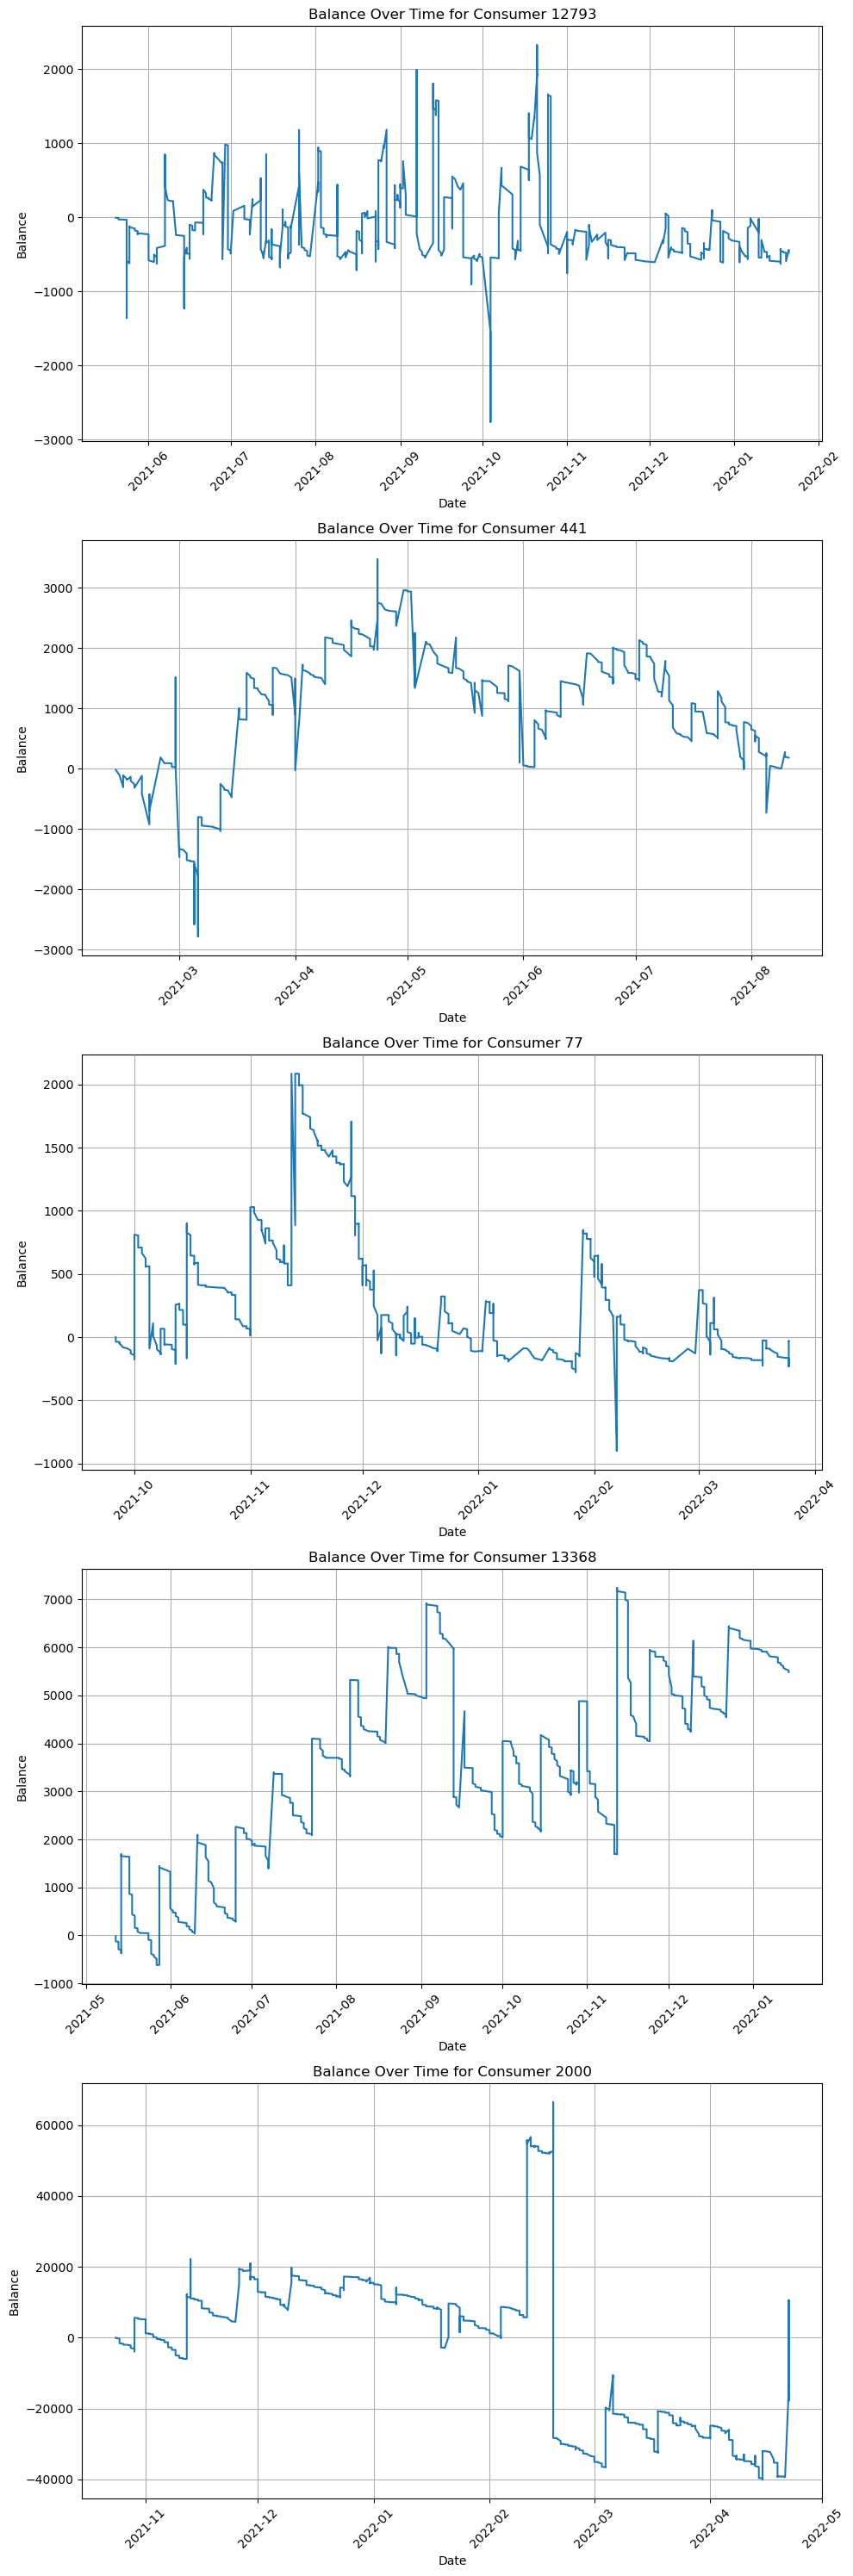

In [18]:
plot_balance_separate_axis(trans_pattern, n=5, dq=0)  

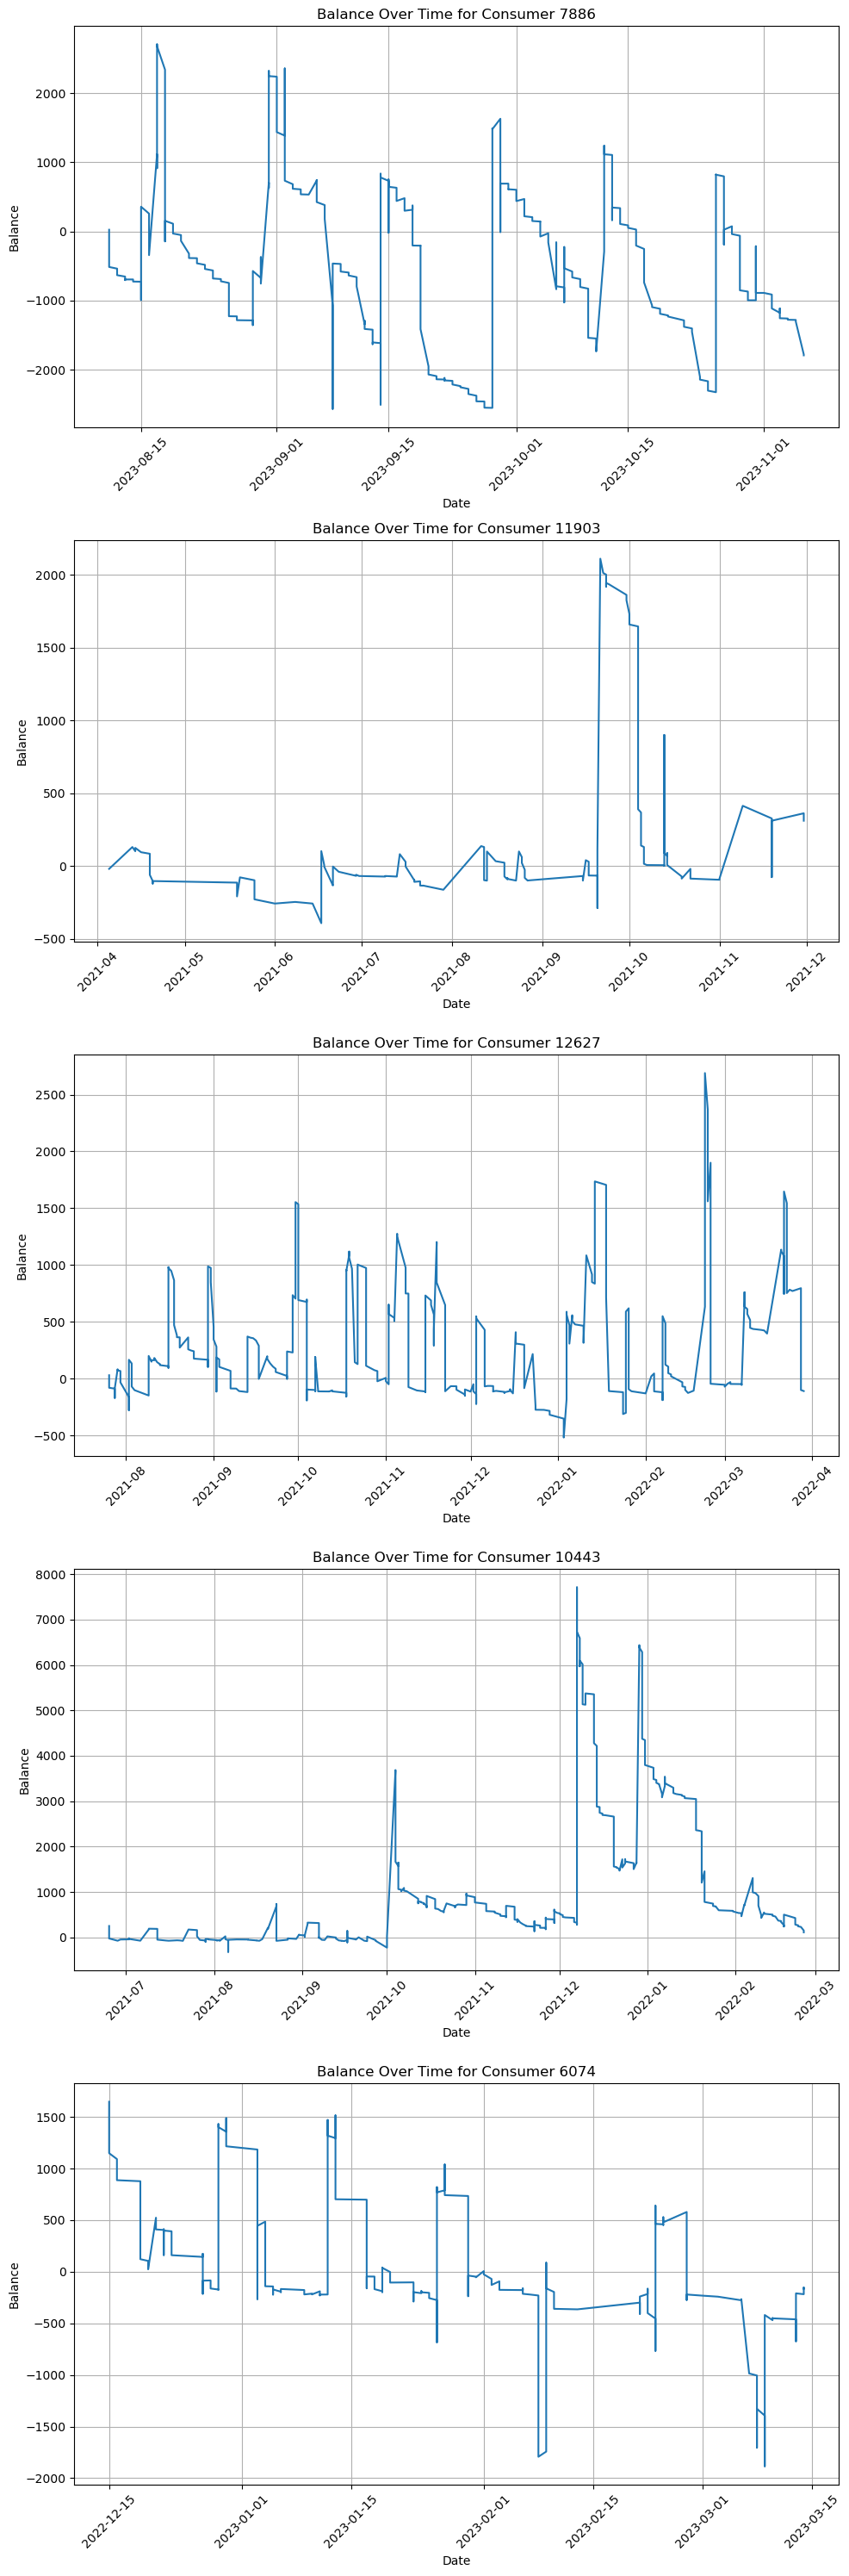

In [19]:
plot_balance_separate_axis(trans_pattern, n=5, dq=1)  

## more attributes

In [20]:
accounts.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90


In [21]:
df = accounts.copy()

# Ensure balance_date is in datetime format
df['balance_date'] = pd.to_datetime(df['balance_date'])

# One-hot encode account_type
one_hot = pd.get_dummies(df['account_type'], prefix='account_type')
one_hot_aggregated = pd.concat([df[['prism_consumer_id']], one_hot], axis=1).groupby('prism_consumer_id').sum()

In [22]:
one_hot_aggregated.head()

,account_type_401K,account_type_AUTO,account_type_BROKERAGE,account_type_CASH MANAGEMENT,account_type_CD,account_type_CHECKING,account_type_CONSUMER,account_type_CREDIT CARD,account_type_HOME EQUITY,account_type_HSA,...,account_type_MONEYMARKET,account_type_MORTGAGE,account_type_OTHER,account_type_OVERDRAFT,account_type_PREPAID,account_type_RETIREMENT,account_type_ROTH,account_type_SAVINGS,account_type_STOCK PLAN,account_type_STUDENT
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
one_hot_eval = one_hot_aggregated.merge(consumer, on="prism_consumer_id")
one_hot_eval

,prism_consumer_id,account_type_401K,account_type_AUTO,account_type_BROKERAGE,account_type_CASH MANAGEMENT,account_type_CD,account_type_CHECKING,account_type_CONSUMER,account_type_CREDIT CARD,account_type_HOME EQUITY,...,account_type_OVERDRAFT,account_type_PREPAID,account_type_RETIREMENT,account_type_ROTH,account_type_SAVINGS,account_type_STOCK PLAN,account_type_STUDENT,evaluation_date,credit_score,DQ_TARGET
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2021-09-01,726.0,0.0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2021-07-01,626.0,0.0
2,10,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2022-02-01,654.0,0.0
3,100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2021-12-01,750.0,0.0
4,1000,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2021-03-01,756.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10403,995,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2021-11-01,728.0,0.0
10404,996,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2021-06-01,729.0,0.0
10405,997,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2022-04-01,809.0,0.0
10406,998,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,2022-04-01,651.0,0.0


In [24]:
test_features = one_hot_eval.columns[1:].drop(['evaluation_date','credit_score','DQ_TARGET'])

In [25]:
run_classification(test_features, "DQ_TARGET", one_hot_eval)

Logistic Regression for Index(['account_type_401K', 'account_type_AUTO', 'account_type_BROKERAGE',
       'account_type_CASH MANAGEMENT', 'account_type_CD',
       'account_type_CHECKING', 'account_type_CONSUMER',
       'account_type_CREDIT CARD', 'account_type_HOME EQUITY',
       'account_type_HSA', 'account_type_IRA', 'account_type_LINE OF CREDIT',
       'account_type_LOAN', 'account_type_MONEY MARKET',
       'account_type_MONEYMARKET', 'account_type_MORTGAGE',
       'account_type_OTHER', 'account_type_OVERDRAFT', 'account_type_PREPAID',
       'account_type_RETIREMENT', 'account_type_ROTH', 'account_type_SAVINGS',
       'account_type_STOCK PLAN', 'account_type_STUDENT'],
      dtype='object')
              precision    recall  f1-score   support

         0.0       0.95      0.59      0.72      1898
         1.0       0.13      0.66      0.22       184

    accuracy                           0.59      2082
   macro avg       0.54      0.62      0.47      2082
weighted avg     

In [26]:
# List of account types for borrowing money
negative_balance_types = [
    'CREDIT CARD', 'LOAN', 'LINE OF CREDIT', 'AUTO', 
    'MORTGAGE', 'STUDENT', 'OVERDRAFT', 'HOME EQUITY'
]

# Function to adjust balances (negative for borrowing account types)
def adjust_balance(row):
    if row['account_type'] in negative_balance_types:
        return -row['balance']
    return row['balance']

df['adjusted_balance'] = df.apply(adjust_balance, axis=1)

# Pivot the data to create columns for each account type, grouping by prism_consumer_id
grouped_df = df.pivot_table(
    index='prism_consumer_id',
    columns='account_type',
    values='adjusted_balance',
    aggfunc='sum',  # Sum balances if there are multiple rows for the same consumer and account type
    fill_value=0
)

In [27]:
grouped_df.head()

account_type,401K,AUTO,BROKERAGE,CASH MANAGEMENT,CD,CHECKING,CONSUMER,CREDIT CARD,HOME EQUITY,HSA,...,MONEYMARKET,MORTGAGE,OTHER,OVERDRAFT,PREPAID,RETIREMENT,ROTH,SAVINGS,STOCK PLAN,STUDENT
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,294.67,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.70,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,91.24,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3211.18,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,822.75,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.49,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,802.40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1853.07,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,95.23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0


In [28]:
acc_balance_eval = grouped_df.merge(consumer, on="prism_consumer_id")
acc_balance_eval

,prism_consumer_id,401K,AUTO,BROKERAGE,CASH MANAGEMENT,CD,CHECKING,CONSUMER,CREDIT CARD,HOME EQUITY,...,OVERDRAFT,PREPAID,RETIREMENT,ROTH,SAVINGS,STOCK PLAN,STUDENT,evaluation_date,credit_score,DQ_TARGET
0,0,0.0,0.0,0.0,0.0,0.0,294.67,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,25.70,0.0,0.0,2021-09-01,726.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,91.24,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3211.18,0.0,0.0,2021-07-01,626.0,0.0
2,10,0.0,0.0,0.0,0.0,0.0,822.75,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.49,0.0,0.0,2022-02-01,654.0,0.0
3,100,0.0,0.0,0.0,0.0,0.0,802.40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1853.07,0.0,0.0,2021-12-01,750.0,0.0
4,1000,0.0,0.0,0.0,0.0,0.0,95.23,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,2021-03-01,756.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10403,995,0.0,0.0,0.0,0.0,0.0,15699.20,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,80136.87,0.0,0.0,2021-11-01,728.0,0.0
10404,996,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2021-06-01,729.0,0.0
10405,997,0.0,0.0,0.0,0.0,0.0,60592.48,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6303.87,0.0,0.0,2022-04-01,809.0,0.0
10406,998,0.0,0.0,0.0,0.0,0.0,813.98,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6080.39,0.0,0.0,2022-04-01,651.0,0.0


In [29]:
test_features = acc_balance_eval.columns[1:].drop(['evaluation_date','credit_score','DQ_TARGET'])
run_classification(test_features, "DQ_TARGET", acc_balance_eval)

Logistic Regression for Index(['401K', 'AUTO', 'BROKERAGE', 'CASH MANAGEMENT', 'CD', 'CHECKING',
       'CONSUMER', 'CREDIT CARD', 'HOME EQUITY', 'HSA', 'IRA',
       'LINE OF CREDIT', 'LOAN', 'MONEY MARKET', 'MONEYMARKET', 'MORTGAGE',
       'OTHER', 'OVERDRAFT', 'PREPAID', 'RETIREMENT', 'ROTH', 'SAVINGS',
       'STOCK PLAN', 'STUDENT'],
      dtype='object')
              precision    recall  f1-score   support

         0.0       0.97      0.39      0.56      1898
         1.0       0.12      0.89      0.22       184

    accuracy                           0.44      2082
   macro avg       0.55      0.64      0.39      2082
weighted avg       0.90      0.44      0.53      2082

ROC-AUC Score: 0.733

Random Forest Classification for Index(['401K', 'AUTO', 'BROKERAGE', 'CASH MANAGEMENT', 'CD', 'CHECKING',
       'CONSUMER', 'CREDIT CARD', 'HOME EQUITY', 'HSA', 'IRA',
       'LINE OF CREDIT', 'LOAN', 'MONEY MARKET', 'MONEYMARKET', 'MORTGAGE',
       'OTHER', 'OVERDRAFT', 'PREPAID', 'R

In [30]:
grouped_std_column_df = grouped_df.copy()

# Exclude the `prism_consumer_id` column from standardization
columns_to_standardize = grouped_std_column_df.columns[1:]  # All columns except the first

# Standardize each column
for column in columns_to_standardize:
    mean = grouped_std_column_df[column].mean()
    std = grouped_std_column_df[column].std()
    grouped_std_column_df[column] = (
        grouped_std_column_df[column] - mean
    ) / std

grouped_std_column_df.rename(
    columns={col: f"std_{col}" for col in grouped_std_column_df.columns if col != 'prism_consumer_id'},
    inplace=True
)

In [31]:
grouped_std_column_df

account_type,std_401K,std_AUTO,std_BROKERAGE,std_CASH MANAGEMENT,std_CD,std_CHECKING,std_CONSUMER,std_CREDIT CARD,std_HOME EQUITY,std_HSA,...,std_MONEYMARKET,std_MORTGAGE,std_OTHER,std_OVERDRAFT,std_PREPAID,std_RETIREMENT,std_ROTH,std_SAVINGS,std_STOCK PLAN,std_STUDENT
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.096505,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,-0.173253,NaN,0.009646
1,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.101682,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,0.010607,NaN,0.009646
10,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.083064,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,-0.174650,NaN,0.009646
100,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.083582,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,-0.067781,NaN,0.009646
1000,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.101580,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,-0.174735,NaN,0.009646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.104004,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,-0.174736,NaN,0.009646
9996,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.097573,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,-0.174736,NaN,0.009646
9997,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.088446,-0.046437,0.087243,0.008768,-0.008768,...,NaN,0.029442,-0.00903,0.008768,-0.010377,-0.009367,-0.015273,-0.174736,NaN,0.009646


In [32]:
acc_balance_std_eval = grouped_std_column_df.merge(consumer, on="prism_consumer_id")
acc_balance_std_eval

,prism_consumer_id,std_401K,std_AUTO,std_BROKERAGE,std_CASH MANAGEMENT,std_CD,std_CHECKING,std_CONSUMER,std_CREDIT CARD,std_HOME EQUITY,...,std_OVERDRAFT,std_PREPAID,std_RETIREMENT,std_ROTH,std_SAVINGS,std_STOCK PLAN,std_STUDENT,evaluation_date,credit_score,DQ_TARGET
0,0,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.096505,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,-0.173253,NaN,0.009646,2021-09-01,726.0,0.0
1,1,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.101682,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,0.010607,NaN,0.009646,2021-07-01,626.0,0.0
2,10,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.083064,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,-0.174650,NaN,0.009646,2022-02-01,654.0,0.0
3,100,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.083582,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,-0.067781,NaN,0.009646,2021-12-01,750.0,0.0
4,1000,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.101580,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,-0.174735,NaN,0.009646,2021-03-01,756.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10403,995,0.0,0.033269,-0.015443,-0.009263,-0.013898,0.295557,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,4.450619,NaN,0.009646,2021-11-01,728.0,0.0
10404,996,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.104004,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,-0.174736,NaN,0.009646,2021-06-01,729.0,0.0
10405,997,0.0,0.033269,-0.015443,-0.009263,-0.013898,1.438139,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,0.189111,NaN,0.009646,2022-04-01,809.0,0.0
10406,998,0.0,0.033269,-0.015443,-0.009263,-0.013898,-0.083288,-0.046437,0.087243,0.008768,...,0.008768,-0.010377,-0.009367,-0.015273,0.176213,NaN,0.009646,2022-04-01,651.0,0.0


In [33]:
def run_classification_axis1(
    feature_column, target_column, dataset, test_size=0.2, random_state=42
):
    """
    Run Logistic Regression and Random Forest Classification on a dataset.

    Parameters:
        feature_column (list): List of columns that can be used as features.
        target_column (str): The name of the target column.
        dataset (pd.DataFrame): The dataset containing the features and target.
        test_size (float): Proportion of the dataset to include in the test split (default 0.3).
        random_state (int): Random seed for reproducibility (default 42).

    Returns:
        None: Prints the classification reports for both models.
    """
    warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)

    # Drop NaN values and shuffle the dataset
    dataset = dataset.dropna(axis=1)

    # Define features and target
    X = dataset[feature_column]
    y = dataset[target_column]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # balance the dataset
    resampler = SMOTETomek(random_state=random_state)
    X_train, y_train = resampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Logistic Regression
    log_model = LogisticRegression(class_weight="balanced", max_iter = 200)
    log_model.fit(X_train, y_train)
    log_y_pred = log_model.predict(X_test)
    log_y_proba = log_model.predict_proba(X_test)[:, 1]
    print(f"Logistic Regression for {feature_column}")
    print(classification_report(y_test, log_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, log_y_proba):.3f}")

    # Random Forest Classification
    rfc_model = RandomForestClassifier(random_state=random_state)
    rfc_model.fit(X_train, y_train)
    rfc_y_pred = rfc_model.predict(X_test)
    rfc_y_proba = rfc_model.predict_proba(X_test)[:, 1]
    print(f"\nRandom Forest Classification for {feature_column}")
    print(classification_report(y_test, rfc_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, rfc_y_proba):.3f}")

    # Light GBM
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    lgb_y_pred = lgb_model.predict(X_test)
    lgb_y_proba = lgb_model.predict_proba(X_test)[:, 1]
    print(f"\nLGB Model Classification for {feature_column}")
    print(classification_report(y_test, lgb_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, lgb_y_proba):.3f}")


    # Balanced Random Forest
    brf_model = BalancedRandomForestClassifier(random_state=random_state)
    brf_model.fit(X_train, y_train)
    brf_y_pred = brf_model.predict(X_test)
    brf_y_proba = brf_model.predict_proba(X_test)[:, 1]
    print(f"\nBalanced Random Forest Classification for {feature_column}")
    print(classification_report(y_test, brf_y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, brf_y_proba):.3f}")

In [34]:
test_features = acc_balance_std_eval.columns[1:].drop(['std_MONEYMARKET', 'std_STOCK PLAN','evaluation_date','credit_score','DQ_TARGET'])
run_classification_axis1(test_features, "DQ_TARGET", acc_balance_std_eval)

Logistic Regression for Index(['std_401K', 'std_AUTO', 'std_BROKERAGE', 'std_CASH MANAGEMENT',
       'std_CD', 'std_CHECKING', 'std_CONSUMER', 'std_CREDIT CARD',
       'std_HOME EQUITY', 'std_HSA', 'std_IRA', 'std_LINE OF CREDIT',
       'std_LOAN', 'std_MONEY MARKET', 'std_MORTGAGE', 'std_OTHER',
       'std_OVERDRAFT', 'std_PREPAID', 'std_RETIREMENT', 'std_ROTH',
       'std_SAVINGS', 'std_STUDENT'],
      dtype='object')
              precision    recall  f1-score   support

         0.0       0.97      0.40      0.56      1898
         1.0       0.12      0.89      0.22       184

    accuracy                           0.44      2082
   macro avg       0.55      0.64      0.39      2082
weighted avg       0.90      0.44      0.53      2082

ROC-AUC Score: 0.732

Random Forest Classification for Index(['std_401K', 'std_AUTO', 'std_BROKERAGE', 'std_CASH MANAGEMENT',
       'std_CD', 'std_CHECKING', 'std_CONSUMER', 'std_CREDIT CARD',
       'std_HOME EQUITY', 'std_HSA', 'std_IRA', '